# City-level Analysis of Human Sentiments of Heat Exposure Using Twitter Data

Author: Fangzheng Lyu

This notebook is related to the paper [Mapping dynamic human sentiments of heat exposure with location-based social media data](https://www.tandfonline.com/doi/full/10.1080/13658816.2024.2343063)

One city-scale analysis was conducted using collected data in the City of Chicago. Unexpected hot weather was detected in Chicago with the highest temperature being 88 degrees Fahrenheit. In this case study, both census tracts and 1 km spatial resolution, with approximately 800 spatial units each for the Cook County, are selected to ensure comprehensive area representation with the amount of social media getting collected. The two spatial unit we select are:
- Census Tracts
- 1km Spatial Resolution

## Notebook Outline
- [Processing Twitter/X Data](#processing)
- [Understanding How Human Sentiments of Heat Exposure from Tweet Posts](#understand)
- [Aggregate the result to the census tract](#aggregate)
- [Visualization - Census Tract](#census)
- [Visualization - 1km Spatial Resolution](#1km)

In [1]:
## Import Library
import pytz
from datetime import datetime, timedelta
import os
import geopandas as gpd
import json
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import re
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np
import random
import csv

/tmp/ipykernel_518/2312993587.py:5: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<a id='processing'></a>

## 1. Processing Twitter/X Data

The following cell will allow users to extract and filter the social media data Twitter/X.

In [2]:
## Load chicago shapefile
shapefile = gpd.read_file("./geo/geo_export_5bb8636f-65b7-450a-8fd9-7f01027fd84b.shp")
chicago_shape = shapefile["geometry"][0]

Filter all the Twitter/X data by location, find all data within the city of Chicago

In [3]:
## get the twitter in chicago
## City scale analysis
## This block of code will takes a long time
## We iterate through all the twitter collected for find twitter in chicago
## Get the filename
filelist = os.listdir('./data/')
filelist

['250000-tweets-2021-09-26_22-13-26.json',
 '250000-tweets-2021-09-26_15-10-52.json',
 '250000-tweets-2021-09-25_20-12-57.json',
 '250000-tweets-2021-09-26_04-56-08.json',
 '250000-tweets-2021-09-25_15-34-24.json',
 '250000-tweets-2021-09-26_01-46-49.json',
 '250000-tweets-2021-09-26_17-16-06.json',
 '250000-tweets-2021-09-25_04-59-49.json',
 '250000-tweets-2021-09-25_07-33-30.json',
 '250000-tweets-2021-09-26_07-36-30.json',
 '250000-tweets-2021-09-25_09-29-48.json',
 '250000-tweets-2021-09-26_09-39-36.json',
 '250000-tweets-2021-09-25_22-39-35.json',
 '250000-tweets-2021-09-26_13-18-44.json',
 '250000-tweets-2021-09-25_01-48-23.json',
 '250000-tweets-2021-09-25_17-48-51.json',
 '250000-tweets-2021-09-26_19-43-23.json',
 '250000-tweets-2021-09-25_13-24-18.json',
 '250000-tweets-2021-09-26_11-29-11.json',
 '250000-tweets-2021-09-25_11-25-23.json']

In [4]:
## select 5 files on 09-25
filelist = ['250000-tweets-2021-09-25_01-48-23.json', 
            '250000-tweets-2021-09-25_04-59-49.json', 
            '250000-tweets-2021-09-25_07-33-30.json',
            '250000-tweets-2021-09-25_09-29-48.json',
            '250000-tweets-2021-09-25_11-25-23.json',
           ]

In [5]:
twitter_in_chicago = []

# Opening JSON file
for filename in filelist:
    filepath = "./data/"+filename
    print(filepath)
    f = open(filepath)
    data = json.load(f)
    
    ## Read the data if the centroid of the twitter point polygon lies within the boundary of the city of Chicago
    for i in range(0, len(data)):
        try:
            ##Need to deal with case when the shapefile is too big
            text = data[i]["text"]
            t = data[i]['created_at']
            ## Case 1
            ## Twitter with exact geospatial location
            if (data[i]['geo']!=None):
                lat = data[i]['geo']['coordinates'][0]
                lon = data[i]['geo']['coordinates'][1]
                exact_loc = Point(lon, lat)
                if chicago_shape.contains(exact_loc):
                    ## print("inside")
                    twitter_in_chicago.append((exact_loc, t, text))
            else:
                ## Twitter with a polygon bounding box
                poly = data[i]['place']['bounding_box']["coordinates"][0]
                lon = -1000
                lat = -1000

                lon = [p[0] for p in poly]
                lat = [p[1] for p in poly]
                centroid = (sum(lon) / len(poly), sum(lat) / len(poly))
                point = Point(centroid)
                ## check if a centroid is in the bounding box of chicago
                if chicago_shape.contains(point):
                    ## print("inside")
                    twitter_in_chicago.append((poly, t, text))
        except:
            ## no geographical location
            pass
    # Closing file
    f.close()

./data/250000-tweets-2021-09-25_01-48-23.json
./data/250000-tweets-2021-09-25_04-59-49.json
./data/250000-tweets-2021-09-25_07-33-30.json
./data/250000-tweets-2021-09-25_09-29-48.json
./data/250000-tweets-2021-09-25_11-25-23.json


In [6]:
print ("There are in total "+str(len(twitter_in_chicago))+" geo-tagged Twitter Collected in Chicago in 9/25/2021 & 9/26/2021")

There are in total 3889 geo-tagged Twitter Collected in Chicago in 9/25/2021 & 9/26/2021


In [7]:
## Example of Twitter Message
twitter_in_chicago[3]

([[-87.940033, 41.644102],
  [-87.940033, 42.023067],
  [-87.523993, 42.023067],
  [-87.523993, 41.644102]],
 'Sat Sep 25 03:35:08 +0000 2021',
 '@_LarroHoops @DariusJButler @NBAxJay1 @BarroomNetwork @dshimon56 That was the pick last week I noted his read and s… https://t.co/DUuZ6v6CWn')

<a id='understand'></a>

## 2. Understanding How Human Sentiments of Heat Exposure from Tweet Posts

The following cell will allow users to apply heat dictionary generated using pretrained NLP model to understand the Twitter post

A keyword-based NLP mehtod is adopted to the generated the heat dictionary. And the heat dictionary is used to access whether each Tweet post is talking about weather and how much is it talking about hot/cold weather.

In [8]:
## Read the word heat dictionary
f = open('./geo/data20000.txt','r')
content = f.read()
f.close()
dict_word = {}
content_list = content.split(",")
for i in range(0,len(content_list)):
    try:
        word = content_list[i].split(":")[0].split("'")[1]
        #print(content_list[i].split(":"))
        val = float(content_list[i].split(":")[1])
        dict_word[word] = val
    except:
        pass

Apply the heat dictionary onto all the Tweets found in the city of Chicago.

In [9]:
## Iterate through all twitter data in chicago

d_twitter = []
for i in range(0, len(twitter_in_chicago)):
    loc = twitter_in_chicago[i][0]
    t = twitter_in_chicago[i][1]
    text = twitter_in_chicago[i][2]
    res = re.findall(r'\w+', text.lower())
    val = 0
    for word in res:
        if word in dict_word.keys():
            val = val + dict_word[word]
    ## remove weather-irrelevant twitter
    ## if none of the word in the heat dictionary show up 
    if (val!=0):
        d_twitter.append((loc, t, val))

In [10]:
print("There are "+str(len(d_twitter))+" weather-related Twitter in Chicago")

There are 167 weather-related Twitter in Chicago


In [11]:
m_dic = {}
m_dic['Jan'] = 1
m_dic['Feb'] = 2
m_dic['Mar'] = 3
m_dic['Apr'] = 4
m_dic['May'] = 5
m_dic['Jun'] = 6
m_dic['Jul'] = 7
m_dic['Aug'] = 8
m_dic['Sep'] = 9
m_dic['Oct'] = 10
m_dic['Nov'] = 11
m_dic['Dec'] = 12

In [12]:
## Find the time difference between the current time and the Twitter post time
today = datetime(2021,9, 25, 0)
weather_related_twitter = []
sec = []
for twitter in d_twitter:
    loc = twitter[0]
    t = twitter[1].split()
    val = twitter[2]
    month = m_dic[t[1]]
    day = int(t[2])
    year = int(t[5])
    hour = int(t[3].split(":")[0])
    minute = int(t[3].split(":")[1])
    twitter_t = datetime(year, month, day, hour, minute)
    diff_minute = abs(twitter_t - today).total_seconds() / 60.0
    weather_related_twitter.append((loc, diff_minute, val))
    sec.append(diff_minute)

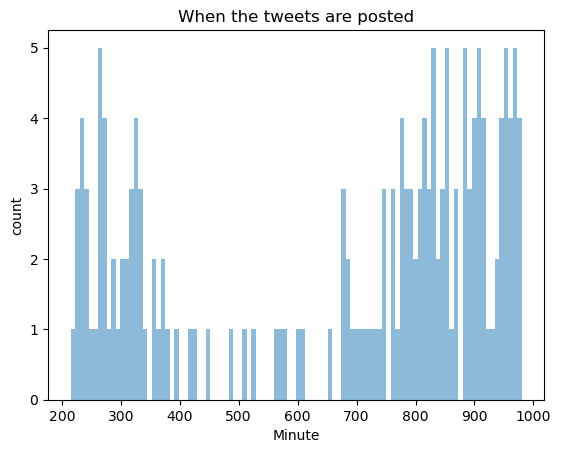

In [13]:
# Let's take a look at the temporal distributed with weather-related Tweets posted across time

plt.hist(sec, bins=100, alpha=0.5)
plt.title('When the tweets are posted')
plt.xlabel('Minute')
plt.ylabel('count')

plt.show()

<a id='aggregate'></a>

## 3. Aggregate the result to the census tract

The following cell will allow users to aggregate the human sentiments of heat exposure from each Tweets to the spaital domain in the city of Chicago.

Aggregate the result into census tract. [Inverse Distance Weighting (IDW)](https://en.wikipedia.org/wiki/Inverse_distance_weighting) is used when a census tract value is missinng.

In [14]:
## Integrate into census tract level
chicago = gpd.read_file("./Census_tract/geo_export_dc0b9c70-c036-4bcc-a602-8e9b9d36ea9f.shp")

In [15]:
chicago

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry
0,44,44.0,031,17031842400,8424,Census Tract 8424,NaN,17,842400,"POLYGON ((-87.62405 41.73022, -87.62405 41.730..."
1,59,59.0,031,17031840300,8403,Census Tract 8403,NaN,17,840300,"POLYGON ((-87.68608 41.82296, -87.68607 41.823..."
2,34,34.0,031,17031841100,8411,Census Tract 8411,NaN,17,841100,"POLYGON ((-87.62935 41.85280, -87.62934 41.852..."
3,31,31.0,031,17031841200,8412,Census Tract 8412,NaN,17,841200,"POLYGON ((-87.68813 41.85569, -87.68816 41.856..."
4,32,32.0,031,17031839000,8390,Census Tract 8390,NaN,17,839000,"POLYGON ((-87.63312 41.87449, -87.63306 41.874..."
...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,17031070400,704,Census Tract 704,NaN,17,070400,"POLYGON ((-87.65746 41.93258, -87.65722 41.932..."
797,7,7.0,031,17031070500,705,Census Tract 705,NaN,17,070500,"POLYGON ((-87.66349 41.93036, -87.66350 41.930..."
798,13,13.0,031,17031130300,1303,Census Tract 1303,NaN,17,130300,"POLYGON ((-87.71436 41.98300, -87.71472 41.982..."
799,29,29.0,031,17031292200,2922,Census Tract 2922,NaN,17,292200,"POLYGON ((-87.71317 41.85523, -87.71357 41.855..."


In [16]:
## Generate a random point from a polygon
import random

def generate_random(number, polygon):
    minx, miny, maxx, maxy = polygon.bounds
    pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    return pnt

In [17]:
## Function to generate random location twitter
## For monte caro experiment
## Enable exact and poly if you want to see how many twitter has exact location and how many comes with a polygon
#exact = 0
#poly = 0
def generate_random_loc(weather_related_twitter):
    random_loc_twitter = []
    for ele in weather_related_twitter:
        loc = ele[0]
        point = 0
        #print(loc)
        if (type(loc)==Point):
            ## exact location extracted
            point = loc
            #exact = exact+1
        else:
            ## Select a random point from a multi-polygon
            point = generate_random(1, Polygon(loc))
            #poly = poly+1
        random_loc_twitter.append([point, ele[2]])
    return random_loc_twitter

In [18]:
d_final_census_track = {}

for i in range(0, 10):
    ## try 10 random time
    print("current "+str(i))

    ## Conduct kernel density estimation
    random_loc_twitter = generate_random_loc(weather_related_twitter)

    ### fill with inverse distance weighting


    for index, row in chicago.iterrows():
        key = index
        ele = row['geometry'] 
        lon = ele.centroid.x
        lat = ele.centroid.y
        ## iterate through all the values in the existing twitter
        up = 0
        down = 0
        IDW = 0
        for twitter in random_loc_twitter:
            pt = twitter[0]
            curr_x = pt.x
            curr_y = pt.y
            curr_val = twitter[1]

            distx = (curr_x-lon)*82
            disty = (curr_y-lat)*111

            w = 1/np.sqrt(distx*distx+disty*disty)

            down = down+w
            up = up+w*curr_val
        rt = up/down

        if (key not in d_final_census_track.keys()):
            d_final_census_track[index]=[rt]
        else:
            d_final_census_track[index].append(rt)

current 0
current 1
current 2
current 3
current 4
current 5
current 6
current 7
current 8
current 9


Calculate Normalized Human Sentiments of Heat Exposure

In [19]:
heat_exposure_map_census_track = {}
for key in d_final_census_track.keys():
    ## Get the average hot exposure
    heat_exposure_map_census_track[key] = np.mean(d_final_census_track[key])

In [20]:
## nomalization to 0-1
mn = min(heat_exposure_map_census_track.values())
mx = max(heat_exposure_map_census_track.values())
for key in heat_exposure_map_census_track.keys():
    norm = (heat_exposure_map_census_track[key]-mn)/(mx-mn)
    heat_exposure_map_census_track[key] = norm

In [21]:
chicago["he_val"]=list(heat_exposure_map_census_track.values())

Show the result geopandas dataframe for visualization

In [22]:
chicago

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry,he_val
0,44,44.0,031,17031842400,8424,Census Tract 8424,NaN,17,842400,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",0.738304
1,59,59.0,031,17031840300,8403,Census Tract 8403,NaN,17,840300,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",0.708867
2,34,34.0,031,17031841100,8411,Census Tract 8411,NaN,17,841100,"POLYGON ((-87.62935 41.85280, -87.62934 41.852...",0.662581
3,31,31.0,031,17031841200,8412,Census Tract 8412,NaN,17,841200,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",0.688659
4,32,32.0,031,17031839000,8390,Census Tract 8390,NaN,17,839000,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",0.652788
...,...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,17031070400,704,Census Tract 704,NaN,17,070400,"POLYGON ((-87.65746 41.93258, -87.65722 41.932...",0.443848
797,7,7.0,031,17031070500,705,Census Tract 705,NaN,17,070500,"POLYGON ((-87.66349 41.93036, -87.66350 41.930...",0.474065
798,13,13.0,031,17031130300,1303,Census Tract 1303,NaN,17,130300,"POLYGON ((-87.71436 41.98300, -87.71472 41.982...",0.715346
799,29,29.0,031,17031292200,2922,Census Tract 2922,NaN,17,292200,"POLYGON ((-87.71317 41.85523, -87.71357 41.855...",0.778346


<a id='census'></a>

## 4. Visualization - Census Tract

The following cell conduct a census tract level analysis of human sentiments of urban heat in the city of Chicago.

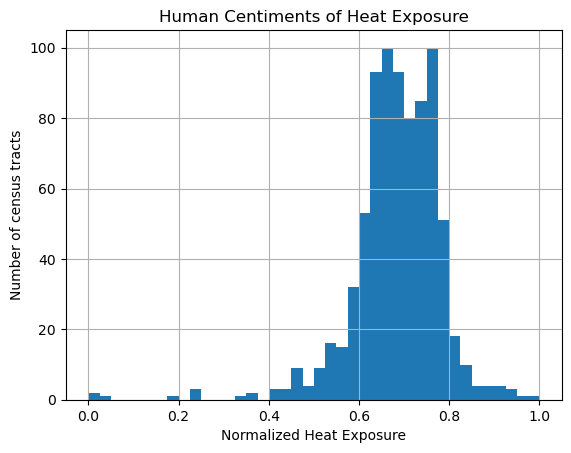

In [23]:
# Let's take a look at how the heat exposure variable is distributed with a histogram
chicago["he_val"].hist(bins=40)
plt.xlabel("Normalized Heat Exposure")
plt.ylabel("Number of census tracts")
plt.title("Human Centiments of Heat Exposure")
plt.show()

<Axes: >

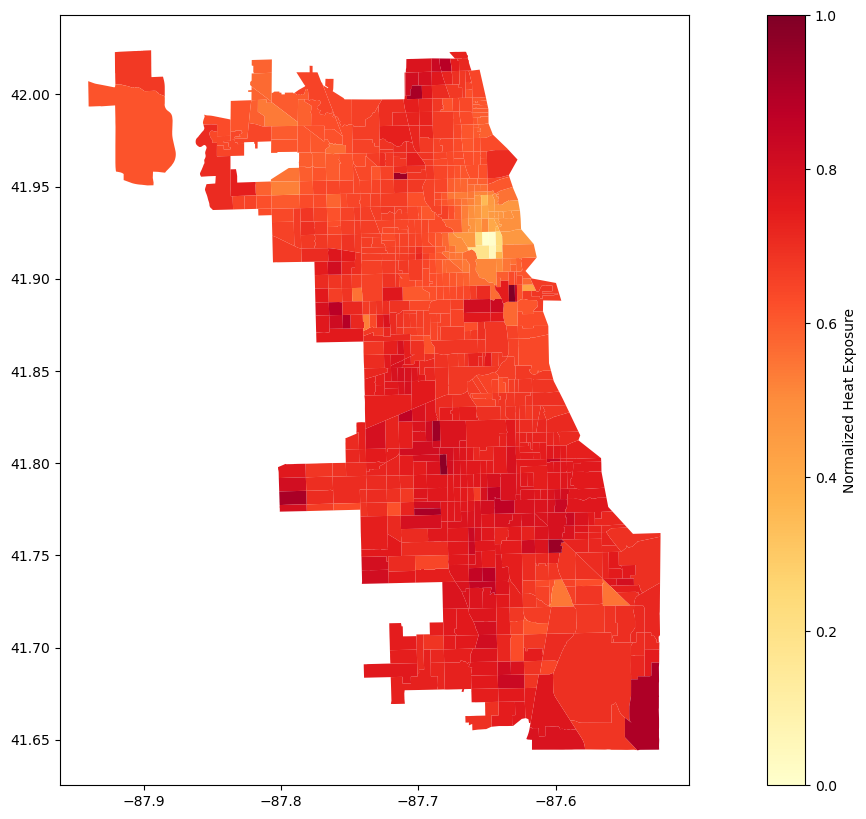

In [24]:
## Creating Choropleth Map with geopandas 
chicago.plot(column = 'he_val', #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd',
                      legend_kwds = {'label': "Normalized Heat Exposure"}) #Name the legend

In [25]:
he_val= list(chicago['he_val'])

In [26]:
## Show the percentile value for 5 classes

print("The 20th percentile is " + str(np.percentile(he_val, 20)))
print("The 40th percentile is " + str(np.percentile(he_val, 40)))
print("The 60th percentile is " + str(np.percentile(he_val, 60)))
print("The 80th percentile is " + str(np.percentile(he_val, 80)))

The 20th percentile is 0.6273367996008387
The 40th percentile is 0.6679606595400209
The 60th percentile is 0.7140796524681143
The 80th percentile is 0.7572530333335324


<Axes: >

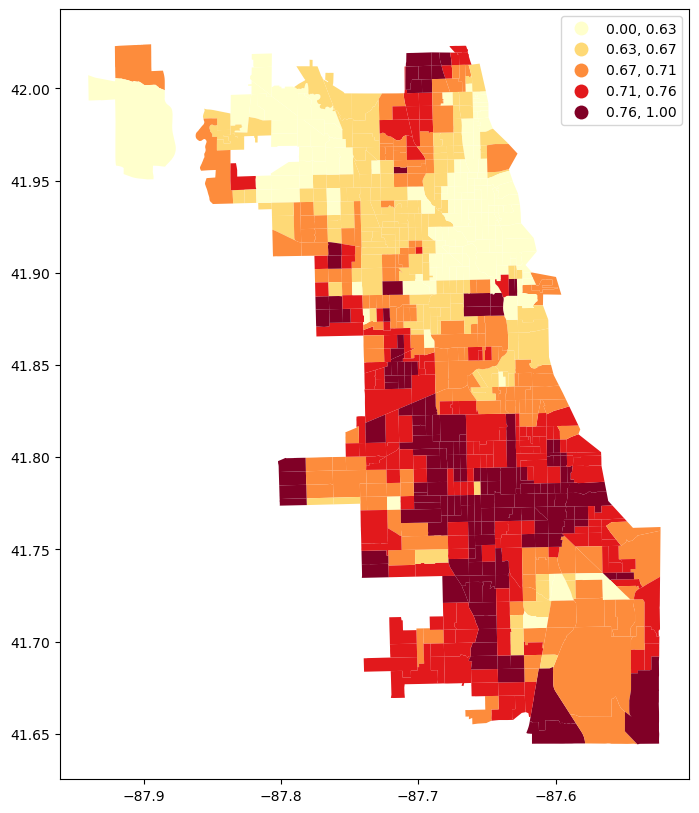

In [27]:
## Quantile Map
chicago.plot(column = 'he_val', #Assign numerical data column
                      scheme="quantiles", 
                      k=5,
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd') #Name the legend

In [28]:
he_val= list(chicago['he_val'])
mn, mx = min(he_val), max(he_val)

In [29]:
mn,mx

(0.0, 1.0)

In [30]:
## Show the equal interval value for 5 class

print("The 1th value is " + str(1*(mx-mn)/5))
print("The 2nd value is " + str(2*(mx-mn)/5))
print("The 3rd value is " + str(3*(mx-mn)/5))
print("The 4th value is " + str(4*(mx-mn)/5))

The 1th value is 0.2
The 2nd value is 0.4
The 3rd value is 0.6
The 4th value is 0.8


<Axes: >

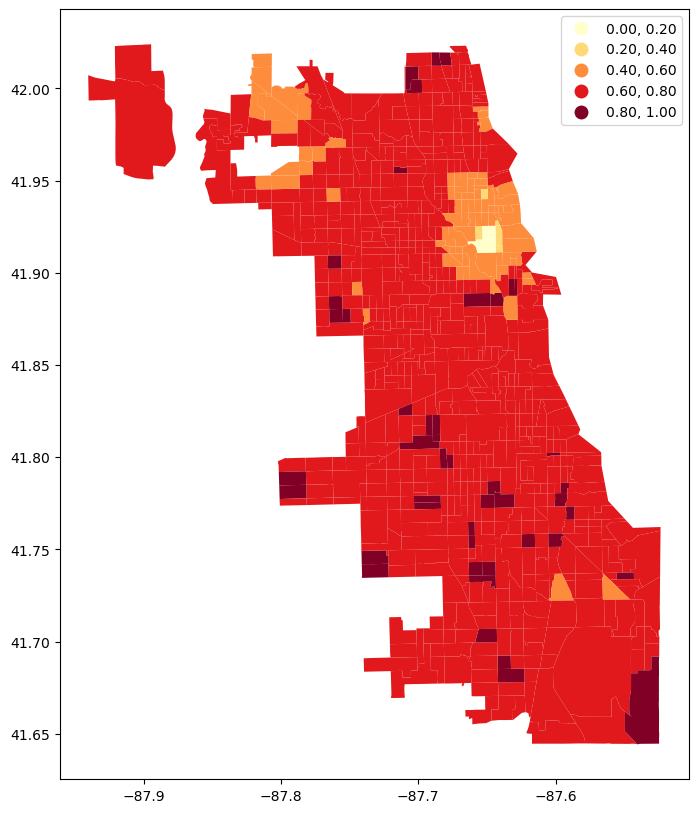

In [31]:
## Equal Interval
chicago.plot(column = 'he_val', #Assign numerical data column
                      scheme="equal_interval", 
                      k=5,
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd') #Name the legend

In [32]:
!pip install jenkspy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.3/622.3 kB 6.7 MB/s eta 0:00:0000:0100:01


In [33]:
import jenkspy
he_val= list(chicago['he_val'])

[a0, a1, a2, a3, a4, a5] = jenkspy.jenks_breaks(he_val, n_classes=5)
print("The 1th value is " + str(a1))
print("The 2nd value is " + str(a2))
print("The 3rd value is " + str(a3))
print("The 4th value is " + str(a4))

The 1th value is 0.2357650119711757
The 2nd value is 0.5775043002396407
The 3rd value is 0.694547462005868
The 4th value is 0.7900570526351784


<Axes: >

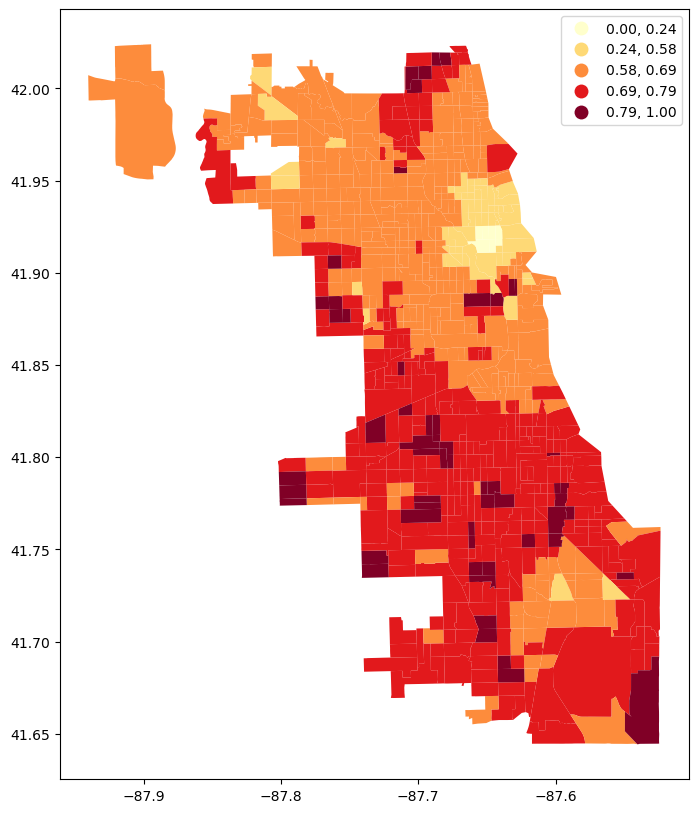

In [34]:
## Natural Break
chicago.plot(column = 'he_val', #Assign numerical data column
                      scheme="natural_breaks", 
                      k=5,
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd') #Name the legend

<a id='1km'></a>

## 5. Visualization - 1km Spatial Resolution

The following cell conduct a analysis of human sentiments of urban heat at 1km spatial resolution in the city of Chicago.

In [35]:
## Generate raster based about 1 km spatial resoltuion 
## one Degree latitude = 111 km
## In chicago, where latitude = 41.881832, one Degree longitude = 82 km
## We use this estimation for the following ananlsis
## This work as the city of Chicago is small
lat_start = 41.05
lon_start = -87.96

incre_lat = 1/111
incre_lon = 1/82

lat_end = 42.05
lon_end = -87.5

raster = []

lat = lat_start

while(lat<lat_end):
    lon = lon_start
    while(lon<lon_end):
        curr_point = Point(lon, lat)
        if (curr_point.within(chicago_shape)):
            raster.append([lon, lat])
        lon = lon+incre_lon
    lat = lat+incre_lat

Generate reuslt for the human sentiments of heat exposure at different timeframe at fine temporal granularity.

In [36]:
## Generate a random point from a polygon
import random

def generate_random(number, polygon):
    minx, miny, maxx, maxy = polygon.bounds
    pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    return pnt

In [37]:
## Function to generate random location twitter
## For monte caro experiment
## Enable exact and poly if you want to see how many twitter has exact location and how many comes with a polygon
#exact = 0
#poly = 0
def generate_random_loc(weather_related_twitter):
    random_loc_twitter = []
    for ele in weather_related_twitter:
        loc = ele[0]
        point = 0
        #print(loc)
        if (type(loc)==Point):
            ## exact location extracted
            point = loc
            #exact = exact+1
        else:
            ## Select a random point from a multi-polygon
            point = generate_random(1, Polygon(loc))
            #poly = poly+1
        random_loc_twitter.append([point, ele[2]])
    return random_loc_twitter

Calcualte the human sentiments of heat exposure. Using Inverse Distance Weighting (IDW) for those spatial unit that doesn't have a points. And using Monte-Carlo simulation to take care of those multi-polygon locations in the social media posts.

In [38]:
## Set seed for reproducibility
## This may take a while

d_final = {}

for i in range(0, 10):
    ## try 100 random time
    print("current "+str(i))

    ## Conduct kernel density estimation
    random_loc_twitter = generate_random_loc(weather_related_twitter)

    ### fill with inverse distance weighting


    for ele in raster:
        lon = ele[0]
        lat = ele[1]
        ## iterate through all the values in the existing twitter
        up = 0
        down = 0
        IDW = 0
        for twitter in random_loc_twitter:
            pt = twitter[0]
            curr_x = pt.x
            curr_y = pt.y
            curr_val = twitter[1]

            distx = (curr_x-lon)*82
            disty = (curr_y-lat)*111

            w = 1/np.sqrt(distx*distx+disty*disty)

            down = down+w
            up = up+w*curr_val
        rt = up/down
        
        key = (ele[0],ele[1])
        if (key not in d_final.keys()):
            d_final[key]=[rt]
        else:
            d_final[key].append(rt)

current 0
current 1
current 2
current 3
current 4
current 5
current 6
current 7
current 8
current 9


In [39]:
heat_exposure_map = {}
for key in d_final.keys():
    ## Get the average hot exposure
    heat_exposure_map[key] = np.mean(d_final[key])

In [40]:
## nomalization to 0-1
mn = min(heat_exposure_map.values())
mx = max(heat_exposure_map.values())
for key in heat_exposure_map.keys():
    norm = (heat_exposure_map[key]-mn)/(mx-mn)
    heat_exposure_map[key] = norm

In [41]:
lonl = []
latl = []
var = []

final_heat_exposure_map = {}
for key in heat_exposure_map.keys():
    
    lonl.append(key[0])
    latl.append(key[1])
    var.append(heat_exposure_map[key])

In [42]:
df = pd.DataFrame(np.column_stack([lonl, latl, var]), 
                  columns=['lon', 'lat', 'val'])

In [43]:
df

,lon,lat,val
0,-87.545366,41.644595,0.671108
1,-87.533171,41.644595,0.786796
2,-87.618537,41.653604,0.686285
3,-87.606341,41.653604,0.736247
4,-87.594146,41.653604,0.730129
...,...,...,...
588,-87.777073,42.013964,0.816358
589,-87.703902,42.013964,0.677113
590,-87.691707,42.013964,0.664389
591,-87.679512,42.013964,0.646698


array([<Axes: xlabel='lon', ylabel='lat'>], dtype=object)

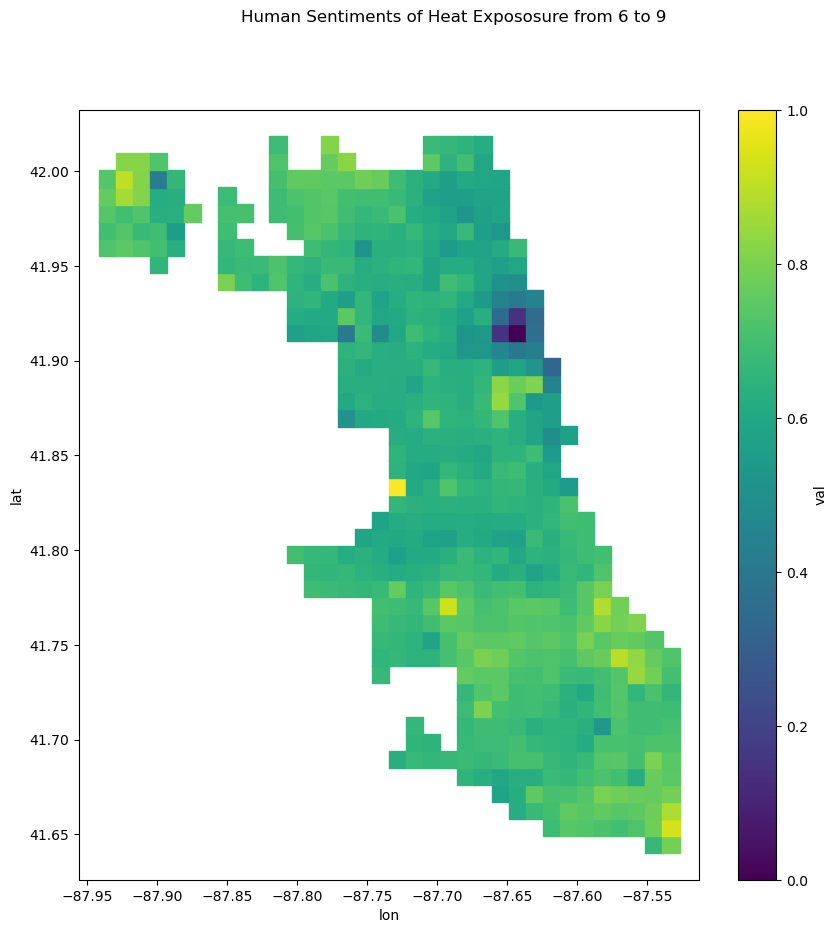

In [44]:
df.plot.scatter(title='Human Sentiments of Heat Expososure from 6 to 9', x='lon', y='lat', c='val', figsize = [10,10], subplots=True, marker="s", s = 155, colormap='viridis')